In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as message
from biogeme import expressions as ex
import pandas as pd
import numpy as np
from scipy import stats
import xlsxwriter
from quetzal.io import excel

# Calibration
## Estimation of the model parameters
quetzal_germany is being estimated using [PandasBiogeme](https://biogeme.epfl.ch/). This notebook estimates calibration parameters for the model's utility functions.
- Documentation and reference: [Bierlaire, M. (2020). A short introduction to PandasBiogeme. Technical report TRANSP-OR 200605. Transport and Mobility Laboratory, ENAC, EPFL.](https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf)
- Tutorial: https://www.youtube.com/watch?v=OiM94B8WayA

### Model formulation
The model consists of systematic utility functions, one for each mode. They comprise an alternaive-specific constant (ASC), a distance-dependent part with travel time and cost summarised as generalised cost (GC), and a cost damping function F

$V_{im} = ASC_{im} + F(GC(T_m, C_m)_i, b_{gc_i})$

Index i marks the demand group. I = {'commuting' (1), 'education' (2), 'shopping/medical' (3), 'business' (4), 'private' (6)}

Note: The cost variable already includes subscriptions

In [3]:
input_path = '../input/'
model_path = '../model/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

### Prepare the database

In [5]:
df = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
df = df[['cost_rail_short', 'cost_rail_long', 'cost_car', 'cost_coach', 'cost_bus', 'cost_walk', 'cost_air',
         'time_rail_short', 'time_rail_long', 'time_car', 'time_coach', 'time_bus', 'time_walk', 'time_air',
         'cost_rail', 'cost_road', 'time_rail', 'time_road',
         'mode_model', 'purpose_vp', 'car_avail', 'length']]
df.columns = ['C_RAIL_Sc', 'C_RAIL_L', 'C_CAR', 'C_COACH', 'C_BUS', 'C_NON_MOTOR', 'C_AIR',
              'T_RAIL_Sc', 'T_RAIL_L', 'T_CAR', 'T_COACH', 'T_BUS', 'T_NON_MOTOR', 'T_AIR',
              'C_RAIL', 'C_ROAD', 'T_RAIL', 'T_ROAD',
              'MODE', 'PURPOSE', 'CAR_AV', 'DIST']

In [6]:
inf = 10000
df = df.replace({np.inf:inf})

In [7]:
df.describe()

,C_RAIL_Sc,C_RAIL_L,C_CAR,C_COACH,C_BUS,C_NON_MOTOR,C_AIR,T_RAIL_Sc,T_RAIL_L,T_CAR,...,T_NON_MOTOR,T_AIR,C_RAIL,C_ROAD,T_RAIL,T_ROAD,MODE,PURPOSE,CAR_AV,DIST
count,94946.000000,94946.000000,94946.000000,94946.000000,94946.000000,94946.0,94946.000000,94946.000000,94946.000000,94946.000000,...,94946.000000,94946.000000,94946.000000,94946.000000,94946.000000,94946.000000,94946.000000,94946.000000,94946.000000,94946.000000
mean,15.768983,88.814431,8.373171,7.578910,5.730818,0.0,9740.479767,741.888468,5251.546286,80.394417,...,4114.579085,9747.870373,18.870131,8.093691,90.445813,1643.598337,5.551893,3.652676,0.965422,95.627377
std,15.053498,53.954227,12.018348,6.738415,2.204967,0.0,1579.148667,2483.023064,4923.840693,85.026095,...,4870.270257,1534.313251,20.390445,6.812647,91.059263,3583.063832,1.349273,2.060002,0.186813,135.609942
min,0.000000,19.000000,0.010944,5.000000,0.000000,0.0,50.000000,17.416667,21.066667,10.400000,...,6.683333,4.126389,0.000000,0.000000,17.416667,18.333333,1.000000,1.000000,0.000000,0.265000
25%,6.218171,25.915510,2.349509,5.000000,5.000000,0.0,10000.000000,35.466667,120.500000,36.483333,...,77.050000,10000.000000,6.969829,5.000000,35.416667,45.966667,6.000000,1.000000,1.000000,29.561000
50%,10.960420,139.000000,4.482873,5.000000,7.000000,0.0,10000.000000,51.183333,10000.000000,49.933333,...,120.933333,10000.000000,11.888226,7.000000,50.583333,73.766667,6.000000,3.000000,1.000000,45.097000
75%,17.742118,139.000000,8.436120,5.000000,7.000000,0.0,10000.000000,104.100000,10000.000000,75.095833,...,10000.000000,10000.000000,21.358977,7.000000,100.866667,247.850000,6.000000,6.000000,1.000000,79.776000
max,50.000000,139.000000,146.982332,60.000000,7.000000,0.0,10000.000000,10000.000000,10000.000000,651.633333,...,10000.000000,10000.000000,139.000000,60.000000,647.675000,10000.000000,7.000000,6.000000,9.000000,1284.894000


In [8]:
# Drop non-motorised trips over 40km, because there are erronous OD pairs
#df = df.loc[~((df['MODE']==7)&(df['DIST']>40))]

In [9]:
# Scale time to hours
df['T_RAIL_S'] = df['T_RAIL'] / 60
df['T_RAIL_Sc_S'] = df['T_RAIL_Sc'] / 60
df['T_RAIL_L_S'] = df['T_RAIL_L'] / 60
df['T_CAR_S'] = df['T_CAR'] / 60
df['T_COACH_S'] = df['T_COACH'] / 60
df['T_BUS_S'] = df['T_BUS'] / 60
df['T_ROAD_S'] = df['T_ROAD'] / 60
df['T_AIR_S'] = df['T_AIR'] / 60
df['T_NON_MOTOR_S'] = df['T_NON_MOTOR'] / 60

In [10]:
# Make car availability binary
df['CAR_AV'] = df['CAR_AV'].replace({9:0})

In [11]:
# Add PT availabilities
df['RAIL_AV'] = (df['T_RAIL']!=inf).astype(int)
df['RAIL_Sc_AV'] = (df['T_RAIL_Sc']!=inf).astype(int)
df['RAIL_L_AV'] = (df['T_RAIL_L']!=inf).astype(int)
df['COACH_AV'] = (df['T_COACH']!=inf).astype(int)
df['BUS_AV'] = (df['T_BUS']!=inf).astype(int)
df['ROAD_AV'] = (df['T_ROAD']!=inf).astype(int)
df['AIR_AV'] = (df['T_AIR']!=inf).astype(int)
df['NON_MOTOR_AV'] = (df['T_NON_MOTOR']!=inf).astype(int)

In [12]:
# Merge rail and road PT
df['MODE'] = df['MODE'].replace({2:1, 3:4})

In [13]:
# Remove trips where mode is car but the car availability is zero
# because it irritates the MLE algorithm
mask = ((df['MODE']==6) & (df['CAR_AV']==0))
drop_ratio = len(df.loc[mask])/len(df.loc[df['MODE']==6])
lengths = list(df.loc[mask, 'DIST'])
print('Share of car trips dropped: {}'.format(drop_ratio))
df = df.loc[~mask]
# Drop other modes equally
#for m in [1,4]:
#    n_drops = int(np.round(drop_ratio * len(df.loc[df['MODE']==m])))
#    df = df.drop(df.loc[(df['MODE']==m) & (df['DIST']<max(lengths)) &
#                        (df['DIST']>min(lengths))].sample(n_drops).index)
#    print('Dropped ' + str(n_drops) + ' trips of mode ' + str(m))
print(len(df))

Share of car trips dropped: 0.0141338950190287
93765


In [14]:
# There is one observation with purpose commuting by air.
# Map it to business trips, because it corrupts the estimation
df.loc[(df['PURPOSE'].isin([1,2]))&(df['MODE']==5), 'PURPOSE'] = 4

In [15]:
# Check that PT trips have no infinity cost
for mode, col in zip([1, 4, 5], ['RAIL_AV', 'ROAD_AV', 'AIR_AV']):
    assert len(df.loc[((df['MODE']==mode) & ~(df[col]))].index) == 0, str(mode)

### Model variables
All columns are variables. DefineVariable creates a new column in the database.

#### Generalised cost

Both, travel time and monetary cost should be affected by cost damping measures. It is logical to define a generalised cost term `GC` with dimension of time units. This requires definition or estimation of values of time, in order to rescale monetary units, for all segments. Usually, the value of time (VoT) is distance-dependent. In the case of Germany, VoT can be taken from research undertaken within the Federal Government's transport study "Bundesverkehrswegeplan 2030": Axhausen et al. 2015. Ermittlung von Bewertungsansätzen für Reisezeiten und Zuverlässigkeit auf der Basis eines Modells für modale Verlagerungen im nicht-gewerblichen und gewerblichen Personenverkehr für die Bundesverkehrswegeplanung

In [16]:
# VoT from literature, distance-dependent, see cal19
VoT = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0)
VoT.sample(2)

,root,Fz1,Fz2,Fz3,Fz4,Fz6,root,Fz1,Fz2,Fz3,...,Fz2,Fz3,Fz4,Fz6,root,Fz1,Fz2,Fz3,Fz4,Fz6
,all,all,all,all,all,all,PT,PT,PT,PT,...,air,air,air,air,car,car,car,car,car,car
328,15.9276,15.3108,9.180,11.900,18.062,12.408,12.1348,9.6076,13.48,14.0432,...,33.2956,33.2956,35.2184,20.9356,15.8408,15.134,9.7788,20.3412,16.9844,12.408
58,10.0040,9.7500,8.964,11.776,11.202,8.502,7.8660,6.7420,9.97,11.2040,...,19.1600,19.1600,24.4700,15.8300,10.1280,9.834,6.7720,13.4640,11.2560,8.502


In [17]:
# Make distance integer
df['DIST'] = df['DIST'].apply(int)

In [18]:
df = df.loc[df['DIST']<=1000]
len(df)

93763

In [19]:
# Generate generalised cost
VoT = VoT.to_dict()
df['GC_RAIL'] = df['T_RAIL_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                  for c,d,p in zip(df['C_RAIL'], df['DIST'], df['PURPOSE'])]
df['GC_RAIL_Sc'] = df['T_RAIL_Sc_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                        for c,d,p in zip(df['C_RAIL_Sc'], df['DIST'], df['PURPOSE'])]
df['GC_RAIL_L'] = df['T_RAIL_L_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                      for c,d,p in zip(df['C_RAIL_L'], df['DIST'], df['PURPOSE'])]
df['GC_COACH'] = df['T_COACH_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                    for c,d,p in zip(df['C_COACH'], df['DIST'], df['PURPOSE'])]
df['GC_BUS'] = df['T_BUS_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                for c,d,p in zip(df['C_BUS'], df['DIST'], df['PURPOSE'])]
df['GC_ROAD'] = df['T_ROAD_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                  for c,d,p in zip(df['C_ROAD'], df['DIST'], df['PURPOSE'])]
df['GC_AIR'] = df['T_AIR_S'] + [c / VoT[('Fz'+str(p), 'air')][d]
                                for c,d,p in zip(df['C_AIR'], df['DIST'], df['PURPOSE'])]
df['GC_CAR'] = df['T_CAR_S'] + [c / VoT[('Fz'+str(p), 'car')][d]
                                for c,d,p in zip(df['C_CAR'], df['DIST'], df['PURPOSE'])]
df['GC_NON_MOTOR'] = df['T_NON_MOTOR_S']

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

<AxesSubplot:>

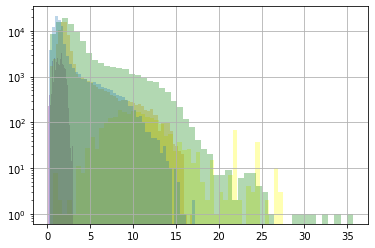

In [20]:
# Distribution of generalised cost by mode
df.loc[df['CAR_AV']==1, 'GC_CAR'].hist(log=True,
    bins=50, alpha=.3, ax=df.loc[df['RAIL_AV']==1, 'GC_RAIL'].hist(log=True,
        bins=50, color='green', alpha=.3, ax=df.loc[df['ROAD_AV']==1, 'GC_ROAD'].hist(log=True,
            bins=50, color='orange', alpha=.3, ax=df.loc[df['NON_MOTOR_AV']==1, 'GC_NON_MOTOR'].hist(log=True,
                bins=50, color='purple', alpha=.3, ax=df.loc[df['AIR_AV']==1, 'GC_AIR'].hist(log=True,
                    bins=50, color='yellow', alpha=.3)))))

<AxesSubplot:>

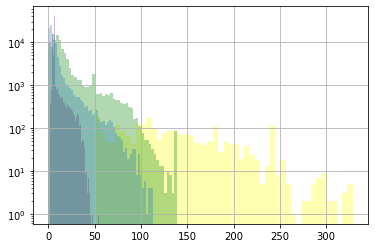

In [21]:
# Distribution of prices by mode
df.loc[df['CAR_AV']==1, 'C_CAR'].hist(log=True,
    bins=50, alpha=.3, ax=df.loc[df['RAIL_AV']==1, 'C_RAIL'].hist(log=True,
        bins=50, color='green', alpha=.3, ax=df.loc[df['ROAD_AV']==1, 'C_ROAD'].hist(log=True,
#            bins=50, color='orange', alpha=.3, ax=df.loc[df['NON_MOTOR_AV']==1, 'C_NON_MOTOR'].hist(log=True,
                bins=50, color='purple', alpha=.3, ax=df.loc[df['AIR_AV']==1, 'C_AIR'].hist(log=True,
                    bins=50, color='yellow', alpha=.3))))#)

<AxesSubplot:>

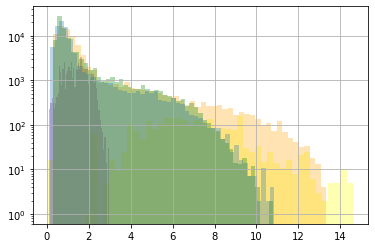

In [22]:
# Distribution of travel times by mode
df.loc[df['CAR_AV']==1, 'T_CAR_S'].hist(log=True,
    bins=50, alpha=.3, ax=df.loc[df['RAIL_AV']==1, 'T_RAIL_S'].hist(log=True,
        bins=50, color='green', alpha=.3, ax=df.loc[df['ROAD_AV']==1, 'T_ROAD_S'].hist(log=True,
            bins=50, color='orange', alpha=.3, ax=df.loc[df['NON_MOTOR_AV']==1, 'T_NON_MOTOR_S'].hist(log=True,
                bins=50, color='purple', alpha=.3, ax=df.loc[df['AIR_AV']==1, 'T_AIR_S'].hist(log=True,
                    bins=50, color='yellow', alpha=.3)))))

#### Cost damping

Many modelling studies have shown that cost damping is required in order to flatten the tail of time/cost elasticities, i.e. decrease the impact of long distances on choice results to prevent from overestimation of time/cost parameters. Cost damping represents the property of decreasing marginal utility. It is commonly approached with Box-Cox transformations of generalised cost (usually defined as the sum of travel time and travel expenditures divided by the value of time). Daly (2010) proposes a hybrid function as a sum of the linear term and the narural logarithm of the same. However, the linear term still dominates cost on long distances. Rich (2020), main developer of the Danish National Transport Model, proposes a more complex spline function which successfully manages cost damping and even outperforms the Box-Cox transformation in terms of stability of elasticities.

In [23]:
# The cost damping function from Rich (2020)
c = params['estimation']
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*ex.Power(ex.log(c1),3),
             -beta/2*ex.log(c1)*(3*ex.Power(ex.log(c2),2)+ex.Power(ex.log(c1),2))] # for Q=3
    theta = [1, 3/2*ex.log(c1), 3*ex.log(c1)*ex.log(c2)] # for Q=3
    return (beta*theta[0]*ex.Power(ex.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*ex.Power(ex.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*ex.Power(ex.log(x),Q-3+1) + alpha[2]) * (x>=c2)

In [24]:
# A Box-Cox transformation can be applied with the following code.
# However, it performs worse than other estimations
#tao_t = {}
#for m in ['CAR', 'RAIL', 'ROAD', 'AIR', 'NON_MOTOR']:
#    assert len(df.loc[df['T_'+m+'_S']<=0]) == 0
#    transformed_data, best_tao = stats.boxcox(df.loc[df[m+'_AV']==1, 'T_'+m+'_S'])
#    tao_t[m] = best_tao
#    df.loc[df[m+'_AV']==1, 'T_'+m+'_D'] = transformed_data
#    df.loc[df[m+'_AV']==0, 'T_'+m+'_D'] = inf

### Database creation

In [25]:
# Create the initial database and make columns global variables
database = db.Database('MiD2017', df.copy())
globals().update(database.variables)
database.getSampleSize()

93763

### Estimation parameters

In [26]:
asc_rail = ex.Beta('asc_rail', 0, None, None, 0)
asc_rail_s = ex.Beta('asc_rail_s', 0, None, None, 0)
asc_rail_l = ex.Beta('asc_rail_l', 0, None, None, 0)
asc_coach = ex.Beta('asc_coach', 0, None, None, 0)
asc_bus = ex.Beta('asc_bus', 0, None, None, 0)
asc_road = ex.Beta('asc_road', 0, None, None, 0)
asc_air = ex.Beta('asc_air', 0, None, None, 0)
asc_car = ex.Beta('asc_car', 0, None, None, 1)
asc_non_motor = ex.Beta('asc_non_motor', 0, None, None, 0)

In [27]:
b_t = ex.Beta('b_t', 0, None, None, 0)
b_c = ex.Beta('b_c', 0, None, None, 0)
b_ac = ex.Beta('b_ac', 0, None, None, 0)

In [28]:
# non-linear time component
b_t2 = ex.Beta('b_t2', 0, None, None, 0)

In [29]:
# generalised cost function parameter
b_gc = ex.Beta('b_gc', 0, None, None, 0)

In [30]:
# Parameter for the model selectivity
phi = ex.Beta('phi', 1, 0, None, 0)

In [31]:
# Parameters for the nested logit structure
mu_pt = ex.Beta('mu_pt', 1, 1, 10, 0)

### Utility functions

In [32]:
# Linear-in-the-parameters formulation
V_RAIL = {p: asc_rail + b_gc * GC_RAIL
          for p in df['PURPOSE'].unique()}
V_ROAD = {p: asc_road + b_gc * GC_ROAD
          for p in df['PURPOSE'].unique()}
V_AIR = {p: asc_air + b_gc * GC_AIR
         for p in df['PURPOSE'].unique()}
V_CAR = {p: asc_car + b_gc * GC_CAR
         for p in df['PURPOSE'].unique()}
V_NON_MOTOR = {p: asc_non_motor + b_gc * GC_NON_MOTOR
               for p in df['PURPOSE'].unique()}

In [33]:
# Model specification with log-power transformation (first component of power-spline)
V_RAIL = {p: asc_rail
              + ex.Power(ex.log(GC_RAIL), 3) * b_gc
          for p in df['PURPOSE'].unique()}
V_ROAD = {p: asc_road
              + ex.Power(ex.log(GC_ROAD), 3) * b_gc
          for p in df['PURPOSE'].unique()}
V_AIR = {p: asc_air
             + ex.Power(ex.log(GC_AIR), 3) * b_gc
         for p in df['PURPOSE'].unique()}
V_CAR = {p: asc_car
             + ex.Power(ex.log(GC_CAR), 3) * b_gc
         for p in df['PURPOSE'].unique()}
V_NON_MOTOR = {p: asc_non_motor 
                   + ex.Power(ex.log(GC_NON_MOTOR), 3) * b_gc
               for p in df['PURPOSE'].unique()}

In [34]:
# Model specification with spline function transformation - GC
c1 = 2
c2 = 5
V_RAIL = {p: asc_rail + spline(GC_RAIL, b_gc, c1, c2)
          for p in df['PURPOSE'].unique()}
V_ROAD = {p: asc_road + spline(GC_ROAD, b_gc, c1, c2)
          for p in df['PURPOSE'].unique()}
V_AIR = {p: asc_air + spline(GC_AIR, b_gc, c1, c2)
         for p in df['PURPOSE'].unique()}
V_CAR = {p: asc_car + spline(GC_CAR, b_gc, c1, c2)
         for p in df['PURPOSE'].unique()}
V_NON_MOTOR = {p: asc_non_motor + spline(GC_NON_MOTOR, b_gc, c1, c2)
               for p in df['PURPOSE'].unique()}

In [35]:
# Model specification with spline function transformation - disaggregated
V_RAIL = {p: asc_rail
              + C_RAIL * b_c
              + spline(T_RAIL, b_t, c['c1_time_'+str(p)]*60, c['c2_time_'+str(p)]*60)
          for p in df['PURPOSE'].unique()}
V_ROAD = {p: asc_road
              + C_ROAD * b_c
              + spline(T_ROAD, b_t, c['c1_time_'+str(p)]*60, c['c2_time_'+str(p)]*60)
          for p in df['PURPOSE'].unique()}
V_AIR = {p: asc_air
             + C_AIR * b_c
             + spline(T_AIR, b_t, c['c1_time_'+str(p)]*60, c['c2_time_'+str(p)]*60)
         for p in df['PURPOSE'].unique()}
V_CAR = {p: asc_car
             + C_CAR * b_c
             + spline(T_CAR, b_t, c['c1_time_'+str(p)]*60, c['c2_time_'+str(p)]*60)
         for p in df['PURPOSE'].unique()}
V_NON_MOTOR = {p: asc_non_motor 
                   + spline(T_NON_MOTOR, b_t, c['c1_time_'+str(p)]*60, c['c2_time_'+str(p)]*60)
               for p in df['PURPOSE'].unique()}

In [36]:
# Model specification for business trips
V_RAIL[4] = asc_rail + spline(T_RAIL, b_t, c['c1_time_4']*60, c['c2_time_4']*60)
V_ROAD[4] = asc_road + spline(T_ROAD, b_t, c['c1_time_4']*60, c['c2_time_4']*60)
V_AIR[4] = asc_air + spline(T_AIR, b_t, c['c1_time_4']*60, c['c2_time_4']*60)
V_CAR[4] = asc_car + spline(T_CAR, b_t, c['c1_time_4']*60, c['c2_time_4']*60)
V_NON_MOTOR[4] = asc_non_motor + spline(T_NON_MOTOR, b_t, c['c1_time_4']*60, c['c2_time_4']*60)

### Run the estimation

In [37]:
# Define level of verbosity
logger = message.bioMessage()
#logger.setSilent()
logger.setWarning()
#logger.setGeneral()
#logger.setDetailed()

In [38]:
# Map modes to utility functions
V = {p: {1:V_RAIL[p],
         4:V_ROAD[p],
         5:V_AIR[p],
         6:V_CAR[p],
         7:V_NON_MOTOR[p]}
     for p in df['PURPOSE'].unique()}

In [39]:
# Map the availability of alternatives with MODE as key
# PT is always available
av = {p: {1:RAIL_AV,
          4:ROAD_AV,
          5:AIR_AV,
          6:CAR_AV,
          7:NON_MOTOR_AV}
      for p in df['PURPOSE'].unique()}

In [40]:
# Mode nests as tuples with nest name and dictionary where
# alternative IDs are mapped to alpha values. Missing ID's alpha is zero
# Alternatively use lists with mode ID without alpha
pt = mu_pt, [1, 4]#[1, 2, 3, 4]
air = 1, [5]
car = 1, [6]
walk = 1, [7]
nests = pt, air, car, walk

In [44]:
# Write results to an Excel file
writer = pd.ExcelWriter(input_path + 'estimation_results_car_own.xls', engine='xlsxwriter')

In [45]:
# Choose the multinomial logit model
mnl = models.loglogit(V[6], av[6], MODE)

In [46]:
database = db.Database('MiD2017', df.copy())
#database.remove(PURPOSE!=4)
model_mnl = bio.BIOGEME(database, mnl)
model_mnl.modelName = 'MNL'

In [47]:
results_mnl = model_mnl.estimate()

In [48]:
results = results_mnl.getEstimatedParameters()
for key, val in results_mnl.getGeneralStatistics().items():
    results.loc[key] = [val[0], val[1]] + ['' for i in range(len(results.columns)-2)]
results

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
asc_air,-1.582465,0.177075,-8.93668,0,0.183738,-8.6126,0
asc_non_motor,-4.126203,0.0474236,-87.0074,0,0.0480675,-85.8419,0
asc_rail,-2.129125,0.0149249,-142.656,0,0.0180261,-118.114,0
asc_road,-2.989952,0.0213506,-140.041,0,0.0209084,-143.003,0
b_c,-0.051962,0.00117378,-44.2688,0,0.00216268,-24.0265,0
b_t,-0.026254,0.000990713,-26.5005,0,0.00100361,-26.1599,0
Number of estimated parameters,6.000000,,,,,,
Sample size,93763.000000,,,,,,
Excluded observations,0.000000,,,,,,
Init log likelihood,-113629.883934,.7g,,,,,


In [49]:
results.to_excel(writer, sheet_name=model_mnl.modelName)

In [50]:
# Choose the logarithmic nested logit model
nl = models.lognested(V[6], av[6], nests, MODE)

In [51]:
# Nested Logit
model_nl = bio.BIOGEME(database, nl)
model_nl.modelName = 'NL'

In [52]:
results_nl = model_nl.estimate()

In [53]:
results = results_nl.getEstimatedParameters()
for key, val in results_nl.getGeneralStatistics().items():
    results.loc[key] = [val[0], val[1]] + ['' for i in range(len(results.columns)-2)]
results

,Value,Active bound,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
asc_air,-1.577044,0,0.159249,-9.90304,0,0.293978,-5.3645,8.11749e-08
asc_non_motor,-4.126081,0,0.0474208,-87.01,0,0.048037,-85.8938,0
asc_rail,-2.129103,0,0.0137489,-154.856,0,0.0281327,-75.6807,0
asc_road,-2.989968,0,1.79769e+308,-1.66322e-308,1,0.181328,-16.4892,0
b_c,-0.051968,0,1.79769e+308,-2.8908e-310,1,0.00650559,-7.98817,1.33227e-15
b_t,-0.026255,0,0.000929699,-28.2401,0,0.00138356,-18.9763,0
mu_pt,1.000000,1,1.79769e+308,5.56268e-309,1,0.173277,5.77112,7.87484e-09
Number of estimated parameters,7.000000,,,,,,,
Sample size,93763.000000,,,,,,,
Excluded observations,0.000000,,,,,,,


In [54]:
results.to_excel(writer, sheet_name=model_nl.modelName)

In [42]:
# Purposes
results = []
for p in [1,2,3,4,6]:
    database = db.Database('MiD2017', df.copy())
    database.remove(PURPOSE!=p)
    print('Sample size for purpose {}: {}'.format(p, database.getSampleSize()))
    mnl = models.loglogit(V[p], av[p], MODE) # Choose utility functions and availabilities
    model = bio.BIOGEME(database, mnl) # Choose the model formulation
    model.modelName = 'MNL_Fz' + str(p) # Name it
    results.append(model.estimate()) # Estimation
    output = results[-1].getEstimatedParameters()
    # Add results to the Excel file
    for key, val in results[-1].getGeneralStatistics().items():
        output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
    output.to_excel(writer, sheet_name=model.modelName)

Sample size for purpose 1: 25365
Sample size for purpose 2: 3559
Sample size for purpose 3: 23010
Sample size for purpose 4: 5614
Sample size for purpose 6: 36215


In [55]:
# Run the estimation by purpose
# These purposes are differentiated by car availability
results = []
for p in [1,2,3,4,6]:
    for car in [0,1]:
        database = db.Database('MiD2017', df.copy())
        database.remove(PURPOSE!=p)
        database.remove(CAR_AV!=car) # seperate models
        print('Sample size for purpose {}, car {}: {}'.format(p, car, database.getSampleSize()))
        mnl = models.loglogit(V[p], av[p], MODE) # Choose utility functions and availabilities
        model = bio.BIOGEME(database, mnl) # Choose the model formulation
        model.modelName = 'MNL_Fz' + str(p) + '_' + str(car) # Name it
        results.append(model.estimate()) # Estimation
        output = results[-1].getEstimatedParameters()
        # Add results to the Excel file
        for key, val in results[-1].getGeneralStatistics().items():
            output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
        output.to_excel(writer, sheet_name=model.modelName)

Sample size for purpose 1, car 0: 645
Sample size for purpose 1, car 1: 24720
Sample size for purpose 2, car 0: 117
Sample size for purpose 2, car 1: 3442
Sample size for purpose 3, car 0: 392
Sample size for purpose 3, car 1: 22618
Sample size for purpose 4, car 0: 98
Sample size for purpose 4, car 1: 5516
Sample size for purpose 6, car 0: 868
Sample size for purpose 6, car 1: 35347


In [56]:
writer.save()